# **Image classificator based on ResNet and TinyImageNet**

**Author:** Vincenzo Barbato - 345728

**Place:** University of Parma

**Date:** 2024


## **Introduction**

### TinyImageNet

TinyImageNet, a dataset of 200 classes derived from ImageNet, contains 100.000 images as a training set (500 per each class), 10.000 as a validation set, and 10.000 as a test set (50 per each class). The training set and validation are labeled, while the test is not labeled.

### ResNet

ResNet, short for Residual Network, is a deep neural network architecture that tackles the training problem by introducing residual connections.
The key idea of ResNet is the utilization of residual blocks, which are building blocks containing skip connections (also known as shortcut connections) to bypass certain layers. These skip connections enable gradients to flow more easily during training, mitigating the issue of vanishing gradients that typically occurs in very deep networks. Consequently, ResNet can effectively train networks with hundreds or even thousands of layers.
A typical residual block consists of two main paths: the identity path and the residual path. The identity path simply forwards the input directly to the output without any alteration. The residual path applies a series of transformations (usually including convolutional layers and activation functions) to the input. The output of the residual block is obtained by adding the input to the output of the residual path. Mathematically, this can be represented as:

<center>

  Output = Input + Residual(Input) 

</center>

This formulation allows the model to learn the residual, or the difference between the desired output and the input, making it easier to optimize the weights of the residual path.

<center>

![Fig.1 - Type of ResNet](../notes/images/resNet_architectures.png)

</center>
<p style="text-align: center;">Fig.1 - Type of ResNet</p>

## **Project assigment**

### Description

Train a model to classify all the images and make some ablation studies you prefer.

In addition, add one ablation study to evaluate how performance vary if the number of classes during the training are 1 or 10 (the last 9 are randomly or carefully selected):

Step (a):

1. choose one class "A" (the one you prefer)
2. train from scratch the model with only the images related to that class "A" you chosen
3. collect info about classification performance (of class "A")

Step (b):

4. choose randomly 9 classes
5. train from scratch the model with the images of class "A" + images of the 9 classes
6. collect info about classification performance (of class "A" and of all 10 classes chosen)
7. repeat points 4,5,6 at least 3 times

Step (c):

8. choose the 9 classes you think most resemble class "A"
9. repeat points 5,6

How the classification performance of class "A" changed?

Could you drawn some conclusions? (e.g. it is better to train the model only with the images of class "A" or not? There are some differences on performance depending of which additional classes you use? …)

### First consideration

To train model to obtain best performance (in term of time and accuracy) we need to consider different aspect.

- The first one is ResNet type, residual network with more layers can classify better the classes of dataset but need more time. Different type of ResNet can need different hyper-parameters configuration. Another aspect is the choice between a Pretrained or Not-Pretrained model.

- The second one is data and batch size. Data with more images can give better performance but need more time to train (according to the batch size).

- The third one are optimizer and learning rate. We focus on SGD and Adam optimizer (the most used).

- The fourth one are hyper-parameters for generalization. We can need to apply dropout on residual block and final layer. We can need weight decay (L2 regularization, default assignable for Adam and SGD optimizer).


## **Dataset**
### Classes for test

The classes randomly selected that we use for test are:

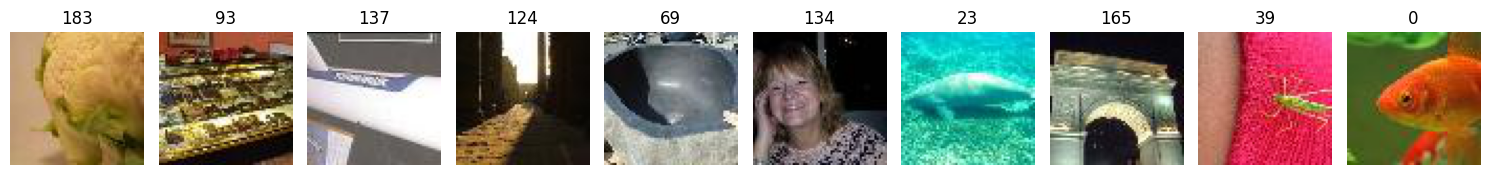

In [8]:
# Run to see the 10 test classes
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from pathlib import Path
from tinyimagenet import TinyImageNet

test = TinyImageNet(
    Path("~/.torchvision/tinyimagenet/"),
    split="val",
    imagenet_idx=False,
    transform=transforms.RandomHorizontalFlip(p=0),
)


def show_images(rows, cols, size, classes):
    newset = []
    plus = np.random.randint(0, 50)
    for i in classes:
        newset.append(test[i * 50 + plus][0])
    fig, axes = plt.subplots(rows, cols, figsize=size)

    for i, ax in enumerate(axes.flat):
        ax.imshow(newset[i])
        ax.axis("off")
        ax.set_title(classes[i])

    plt.tight_layout()
    plt.show()


classes = [183, 93, 137, 124, 69, 134, 23, 165, 39, 0]
show_images(1, 10, (15, 15), classes)

### Augmentation

As already mentioned, the test set is not labeled. A model to begin well needs a large and good-quality dataset:

- With high-quality data, it is possible to train a model to learn good features.
- With a lot of data, it is possible to prevent overfitting and have more features for training.

For example, CIFAR-10 has 60.000 images of size 32x32 for 10 classes.

For these reasons, we use all 500 images for training and the 50 images of the validation set for validation and testing.

To improve the features and the amount of data artificially, it is possible to apply data augmentation to the training set (only the training set because it is better that the validation and test sets remain as original images).
As Tiny ImageNet is derived from ImageNet, we use ImageNet data augmentation.

Example transformations:


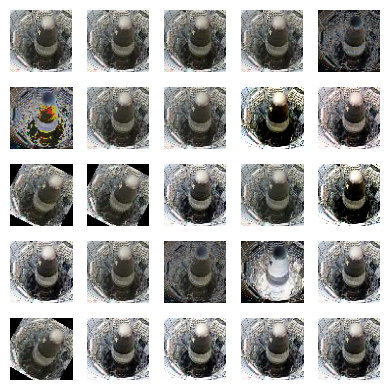

In [9]:
# Run to see data augmentation in action
policy = transforms.AutoAugmentPolicy.IMAGENET
augmenter = transforms.AutoAugment(policy)
transform = transforms.Compose(
    [
        augmenter,
    ]
)

newset = []
index = np.random.randint(0, len(test))

newset.append(test[index][0])

for i in range(24):
    newset.append(transform(test[index][0]))

fig, axes = plt.subplots(5, 5, figsize=(4, 4))

for i, ax in enumerate(axes.flat):
    ax.imshow(newset[i])
    ax.axis("off")

plt.tight_layout()
plt.show()

#### No augmentation vs Offline augmentation consideration

For offline augmentation we mean an augmentation applied before the training.

<div align="center">

| Train Set    | Data Augmentation | Test Loss | Accuracy | F-Measure | Recall | Precision | Training Time         |
| ------------ | ----------------- | --------- | -------- | --------- | ------ | --------- | --------------------- |
| 5000 images  | Not Applied       | 1.309     | 0.576    | 0.578     | 0.576  | 0.581     | 1 minutes, 21 seconds |
| 35000 images | Applied           | 1.329     | 0.622    | 0.624     | 0.622  | 0.625     | 2 minutes, 47 seconds |

<p style="text-align: center">Table 1</p>
<p style="text-align: center">NP-ResNet18, Test on 10 classes, BS 32, LR 0.001, momentum 0.9, dropout 0, L2 0.0</p>

</div>

Data augmentation helps to improve model performances and generalization. Obviously it will be used in accord with other parameters and computer memory.

From the graph of accuracy and loss, it is possible to see that augmentation helps to improve the metrics, but the model starts to overfit immediately.

In [ ]:
# The command to run tensorboard are write for semplify the visualization.
# To prevent setup problem is suggested open a terminal in the "notes" folder and run the command.
tensorboard --logdir_spec noAugTrain:"../results/no_aug/logsTrain",noAugVal:"../results/no_aug/logsVal",augOfflineTrain:"../results/aug_offline/logsTrain",augOfflineVal:"../results/aug_offline/logsVal"

#### Online augmentation vs Offline augmentation consideration

For online augmentation we mean an augmentation applied before the training and every step size.

<div align="center">

| Train Set    | Data Augmentation       | Test Loss | Accuracy | F-Measure | Recall | Precision | Training Time         |
| ------------ | ----------------------- | --------- | -------- | --------- | ------ | --------- | --------------------- |
| 20000 images | Applied every 2 epochs  | 1.061     | 0.664    | 0.670     | 0.664  | 0.667     | 2 minutes, 48 seconds |
| 35000 images | Applied before training | 1.329     | 0.622    | 0.624     | 0.622  | 0.625     | 2 minutes, 47 seconds |

<p style="text-align: center">Table 2</p>
<p style="text-align: center">NP-ResNet18, Test on 10 classes, BS 32, LR 0.001, momentum 0.9, dropout 0.0, L2 0.0</p>

</div>

Online augmentation helps to improve metrics and control overfitting. The time needed for training probably increases with the number of epochs and the dropout step size.


In [ ]:
# The command to run tensorboard are write for semplify the visualization.
# To prevent setup problem is suggested open a terminal in the "notes" folder and run the command.
tensorboard --logdir_spec augOnlineTrain:"../results/aug_online/logsTrain",augOnlineVal:"../results/aug_online/logsVal",augOfflineTrain:"../results/aug_offline/logsTrain",augOfflineVal:"../results/aug_offline/logsVal"

### Improve images resolution

Now we try to improve image resolution to see if model learn feature more easily.
Is important to specify that the size and number of usable images is directly connected to the computer memory and computational power.

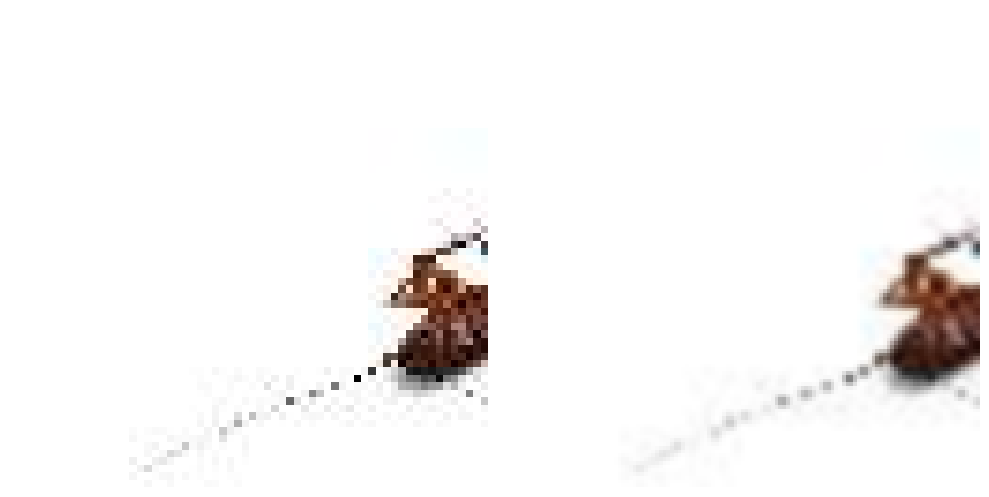

In [10]:
# A visible result of the effects of images resolution improvement
transform = transforms.Compose(
    [
        transforms.Resize(
            [128, 128], interpolation=transforms.InterpolationMode.BICUBIC
        ),
        transforms.GaussianBlur(kernel_size=(3, 3), sigma=(1)),
    ]
)
index = np.random.randint(0, len(test))
newset = []
newset.append(test[index][0])
newset.append(transform(test[index][0]))

fig, axes = plt.subplots(1, 2, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(newset[i])
    ax.axis("off")

plt.tight_layout()
plt.show()

<div align="center">

| Image Size     | Test Loss | Accuracy | F-Measure | Recall | Precision | Training Time         |
| -------------- | --------- | -------- | --------- | ------ | --------- | --------------------- |
| 64x64 images   | 1.061     | 0.664    | 0.670     | 0.664  | 0.667     | 2 minutes, 48 seconds |
| 128x128 images | 0.872     | 0.728    | 0.734     | 0.728  | 0.741     | 6 minutes, 40 seconds |

<p style="text-align: center">Table 4</p>
<p style="text-align: center">NP-ResNet18, Test on 10 classes (20000 images with online aug. of 3 every 2 step), BS 32, LR 0.001, momentum 0.9, dropout 0.0, L2 0.0</p>

</div>

Like the previous result, we have an improvement in metrics, but the time needed to train the model has tripled. Is obvious that the improvement of image resolution can have more or less satisfactory results based on resizing and source image.
With more memory and computation power it would be possible to use image from **224x224** and over and more data augmentation to improve network performances.

In [ ]:
# The command to run tensorboard are write for semplify the visualization.
# To prevent setup problem is suggested open a terminal in the "notes" folder and run the command.
tensorboard --logdir_spec augOnlineTrain:"../results/aug_online/logsTrain",augOnlineVal:"../results/aug_online/logsVal",imgImproveTrain:"../results/image_improvement/logsTrain",imgImproveVal:"../results/image_improvement/logsVal"

### Final dataset considerations

The initial hypothesis of this paragraph was that the quantity and quality of data have a significant impact on model training.

We started the test with a dataset consisting of 500 training images, each 64x64 pixels, per class. By augmenting the data and improving the image resolution, we increased the dataset to 2000 training images, each 128x128 pixels, per class, with a dataset refresh every N epochs.

These tecniques led us to get:
- Loss improvement of 0.437
- Accuracy improvement of 0.152

The time needed to train the model increased by 5 minutes and 19 seconds.
Another important factor is the difference between the images subjects. We chose the subjects randomly, but the differences and similarities between the subjects can either help the model learn the features and recognize them better or make it worse.
An example of this is the similarity between towers and rockets.

In all TensorBoard logs, in addition to metrics, the **IMAGES** section includes the confusion matrix to visualize and understand this concept.

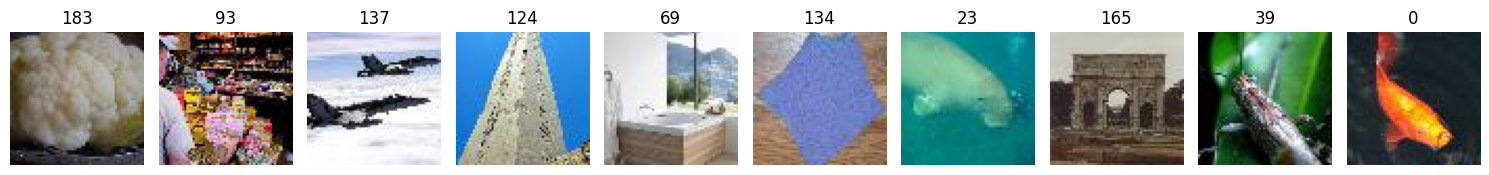

In [11]:
# Run to see the 10 test classes
classes = [183, 93, 137, 124, 69, 134, 23, 165, 39, 0]
show_images(1, 10, (15, 15), classes)

<div align="center">

<figure>
    <img src="../notes/images/improveImagesResolution.png" alt="" style="width: 600px;"/>
    <figcaption>Fig. 2 - Confusion matrix taken from logs of last test (Improve images resolution)</figcaption>
</figure>

</div>

We can see that the network learn better the feature of classes 93, 124, 23 and 165.
Less better class 183 and 0, and with high difficult 137, 69, 134 and 39.


## **Architecture of Residual Network**

### Resnet block

For the studies we choose resNet18, for its simplicity and shorter training time compared to other residual networks, resNet50 and resNet101 to observe the difference with deeper networks.

The model is loaded from Pytorch Hub, it is a pretrained model repository designed to facilitate research reproducibility. Is possible to load Pretrained or Not-Pretrained model.

The possible blocks of resNet are BasicBlock or Bottleneck:

<div align="center">
<table>
<tr>
    <th>BasicBlock</th>
    <th>Bottleneck</th>
</tr>
<tr>
    <td style="vertical-align: top;">
<pre>

    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)

    if self.downsample is not None:
        identity = self.downsample(x)

    out += identity
    out = self.relu(out)

    return out

</pre>
    </td>
    <td style="vertical-align: top;">
<pre>

    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)

    out = self.conv3(out)
    out = self.bn3(out)

    if self.downsample is not None:
        identity = self.downsample(x)

    out += identity
    out = self.relu(out)

    return out

</pre>
    </td>
</tr>
</table>

Table 5</br>

</div>


### Dropout

Dropout is a regularization technique used in neural networks to prevent overfitting. It works by randomly deactivating (setting to zero) a fraction of neurons during training, which forces the network to learn redundant representations and prevents it from relying too much on specific neurons. This encourages the network to generalize better to unseen data.
Dropout is applied independently to each neuron, so different neurons are dropped out at each iteration.

#### Dropout in the residuals blocks

The basic idea of dropout on residual block is that too dropout can block the learning of important features because the dropout of residual block is less than dropout on fc layers.

In this study we analyze the result of different dropout position in the residual block and in the head of resNet (Different network configuration available to [link](../notes/network.ipynb) or is possible see the same network configuration in a tensorboard graph).

Common usege says to apply dropout after each ReLU. The difference of appling dropout before or after ReLU are insignificant. Dropout and ReLU are a permutable operation [[1](https://doi.org/10.48550/arXiv.2302.06112)]:

<div align="center">ReLU(Dropout(x)) = Dropout(ReLU(x)) </div>
<div></div>
<div></div>

<div align="center">
<p style="text-align: center">The results confirm that dropout and relu are a permutable operation.</p>

| Experiment          | Early Stop Epoch | Test Loss | Accuracy | F-Measure | Recall | Precision | Training Time          |
| ------------------- | ---------------- | --------- | -------- | --------- | ------ | --------- | ---------------------- |
| Dropout before ReLU | 57               | 0.647     | 0.790    | 0.792     | 0.790  | 0.794     | 47 minutes, 20 seconds |
| Dropout after ReLU  | 56               | 0.646     | 0.788    | 0.788     | 0.788  | 0.787     | 47 minutes, 6 seconds  |

<p style="text-align: center">Table 6</p>
<p style="text-align: center">NP-ResNet18, Test on 10 classes (20000 images with online aug. of 3 every 2 step), BS 32, LR 0.001, momentum 0.9, dropout_rb 0.1, dropout_fc 0.0, L2 0.0 </p>

</div>

This solution works good, but the control on dropout rate is small, especially if we want to compare different networks. We have tested, for example, a dropout of 0.3 and the model went in underfitting. The reason is that this solution applies dropout after or before each ReLU. Therefore if we consider **basicBlock** we have applied dropout to 2 ReLU layers, but if we consider **bottleneck** we have applied dropout to 3 ReLU layers (see table 5).

Another possibility is apply one dropout layer for each block, the best position is before or after relu and before the identity [[1](https://doi.org/10.48550/arXiv.2302.06112)]. If apply dropout before or after is not a problem as mentioned in the previous result.

<div align="center">

| Experiment                          | Early Stop Epoch | Test Loss | Accuracy | F-Measure | Recall | Precision | Training Time                  |
| ----------------------------------- | ---------------- | --------- | -------- | --------- | ------ | --------- | ------------------------------ |
| One dropout for each residual block | 76               | 0.650     | 0.776    | 0.776     | 0.776  | 0.776     | 1 hours, 1 minutes, 25 seconds |

<p style="text-align: center">Table 7</p>
<p style="text-align: center">NP-ResNet18, Test on 10 classes (20000 images with online aug. of 3 every 2 step) BS 32, LR 0.001, momentum 0.9, dropout_rb 0.5, dropout_fc 0.0, L2 0.0 </p>

</div>

In this way is more simple managing dropout without the risk of underfitting.


In [ ]:
# We have removed the unnecessary checkpoints because they were taking up too much space

# The command to run tensorboard are write for semplify the visualization.
# To prevent setup problem is suggested open a terminal in the "notes" folder and run the command.
tensorboard --logdir_spec beforeReluTrain:"../results/dropout_before_relu/logsTrain",beforeReluVal:"../results/dropout_before_relu/logsVal",afterReluTrain:"../results/dropout_after_relu/logsTrain",afterReluVal:"../results/dropout_after_relu/logsVal",oneTrain:"../results/one dropout_foreach_resblock/logsTrain",oneVal:"../results/one dropout_foreach_resblock/logsVal"

In the same way we check the best position for dropout in the head. ResNet head is a simple sequence of AdaptiveAvgPool and linear layer that have as input the output of AdaptiveAvgPool and as output the number of classes that we want to classify.

Because the two possible position of dropout layer are before or after the AdaptiveAvgPool [[1](https://doi.org/10.48550/arXiv.2302.06112)].

<div align="center">
<p style="text-align: center">Best results out of 5 </p>

| Experiment                     | Early Stop Epoch | Test Loss | Accuracy | F-Measure | Recall | Precision | Training Time                   |
| ------------------------------ | ---------------- | --------- | -------- | --------- | ------ | --------- | ------------------------------- |
| Dropout before AdaptiveAvgPool | 92               | 0.630     | 0.792    | 0.790     | 0.792  | 0.789     | 1 hours, 14 minutes, 32 seconds |
| Dropout after AdaptiveAvgPool  | 117              | 0.605     | 0.794    | 0.794     | 0.794  | 0.795     | 1 hours, 34 minutes, 57 seconds |

<p style="text-align: center">Table 8</p>
<p style="text-align: center">NP-ResNet18, Test on 10 classes (20000 images with online aug. of 3 every 2 step), BS 32, LR 0.001, momentum 0.9, dropout_rb 0.5, dropout_fc 0.5, L2 0.0 </p>


In [ ]:
# We have removed the unnecessary checkpoints because they were taking up too much space

# The command to run tensorboard are write for semplify the visualization.
# To prevent setup problem is suggested open a terminal in the "notes" folder and run the command.
tensorboard --logdir_spec beforeAvgTrain:"../results/dropout_before_avg/logsTrain",beforeAvgVal:"../results/dropout_before_avg/logsVal",afterAvgTrain:"../results/dropout_after_avg/logsTrain",afterAvgVal:"../results/dropout_after_avg/logsVal"

### Final Architecture of Residual Network considerations

We have seen that the residual networks loaded from PyTorch consist of a series of BasicBlock and Bottleneck layers. These blocks automatically include batch normalization but not dropout.

For these reasons, we searched for the best position for dropout to improve network performance.

By adding one dropout layer for each block and one dropout layer in the head after the adaptive average pooling layer, the loss improved by 0.267, the accuracy by 0.066 and we have a good control on dropout rate. However, the training time increased from less than 10 minutes to more than one hour.

## **Learning rate and batch size**

Possible technique to perform better your neural network are gridSearch and bayesSearch, but this approach needs more time, especially if we have a lot of parameters to set.

- Learning rate: in machine learning is like the pace at which a model learns. It determines how big or small the steps are during training. Too high, and it might overshoot; too low, and it might be too slow.

- Batch size: when training a neural network, data is divided into smaller batches, and the model’s parameters are updated based on the average gradient computed from each batch. The choice of batch size impacts training efficiency, memory usage, and convergence behavior. Larger batch sizes can speed up training but require more memory, while smaller batch sizes may lead to more frequent parameter updates but slower convergence.

These parameters affect the training time and performance.

When training a neural network, it is important to consider the training time, as efficient and timely training can lead to faster iterations, frequent model updates, greater scalability, and increased practicality in the production environment. However, it is essential to balance this with other critical factors such as model accuracy, robustness, and interpretability.

For this reason, the research [[2](https://doi.org/10.48550/arXiv.1711.00489)] was considered, which, in addition to decreasing the learning rate, also increases the batch size, thereby reducing the number of parameters updated in each epoch and, consequently, decreasing the time required to train the model.
In the research, a very large batch size is used, which is not possible in this project; therefore, the initial learning rate, maximum learning rate, initial batch size, maximum batch size, and increment factor have been adapted to the available computational capabilities, all while trying to divide the training into 3 steps.

<div align="center">

| Experiment          | Gamma          | Step | Early stop at epoch | Test loss | Accuracy | F-Measure | Recall | Precision | Training time          |
| ------------------- | -------------- | ---- | ------------------- | --------- | -------- | --------- | ------ | --------- | ---------------------- |
| Decay learning rate | LR:0.3, BS:1.0 | 14   | 25                  | 0.667     | 0.772    | 0.768     | 0.772  | 0.764     | 19 minutes, 34 seconds |
| Increase batch size | LR:1.0, BS:3.0 | 14   | 23                  | 0.738     | 0.742    | 0.742     | 0.742  | 0.742     | 17 minutes, 5 seconds  |
| Hybrid              | LR:0.3, BS:3.0 | 14   | 46                  | 0.702     | 0.748    | 0.747     | 0.748  | 0.745     | 35 minutes, 1 seconds  |

<p style="text-align: center">Table 9</p>
<p style="text-align: center">NP-ResNet18, Test on 10 classes (20000 images with online aug. of 3 every 2 step), start BS 32, start LR 0.1, momentum 0.9, dropout_rb 0.5, dropout_fc 0.5, L2 0.0</p>

</div>

Due to computational limits, we set the minimum learning rate to 0.0001 and the maximum batch size to 256.
As mentioned in the research [[2](https://doi.org/10.48550/arXiv.1711.00489)], with this approach is possible obtain a significant decrement of training time with a little worst results.
The researchers has set the max batch size to 5120, because for us is not possible use this method.

In any case, the initial goal was to reduce training time while trying not to worsen the metrics. The tasks assigned for this project are a study on 10 classes with a model trained from scratch, and a study on all 200 classes without particular constraints. For this reason, we will keep the model without schedulers for the first task, verifying the possibility of using deeper networks, and for the 200 classes we will consider fine-tuning and transfer learning.


In [ ]:
# We have removed the unnecessary checkpoints because they were taking up too much space

# The command to run tensorboard are write for semplify the visualization.
# To prevent setup problem is suggested open a terminal in the "notes" folder and run the command.
tensorboard --logdir_spec bsTrain:"../results/step/bs/logsTrain",bsVal:"../results/step/bs/logsVal",lrTrain:"../results/step/lr/logsTrain",lrVal:"../results/step/lr/logsVal",hybridTrain:"../results/step/hybrid/logsTrain",hybridVal:"../results/step/hybrid/logsVal"

## **Pretrained or not-pretrained model and comparison between resNet18 and resNet50**

The difference between pretrained and not-pretrained models is how they begin learning. For training from scratch is used weight initialization, while for the pre-trained models, they use the weights taken from imagenet1k_v1.
<div align="center">

| Experiment                                       | Early stop at epoch | Test loss | Accuracy | F-Measure | Dropout rb | Dropout fc | Training time                   |
| ------------------------------------------------ | ------------------- | --------- | -------- | --------- | ---------- | ---------- | ------------------------------- |
| Pretrained ResNet18 with weights initialization  | 124                 | 0.615     | 0.822    | 0.823     | 0.5        | 0.6        | 1 hours, 36 minutes, 3 seconds  |
| esNet50 with weights initialization              | 110                 | 0.627     | 0.792    | 0.791     | 0.3        | 0.4        | 2 hours, 43 minutes, 11 seconds |
| Pretrained ResNet101 with weights initialization | 85                  | 0.715     | 0.766    | 0.769     | 0.2        | 0.3        | 3 hours, 3 minutes, 34 seconds  |
| earning ResNet18 with imagenet1k_v1              | 50 max epoch limit  | 0.294     | 0.912    | 0.913     | 0.0        | 0.0        | 28 minutes, 54 seconds          |
| Transfer learning ResNet50 with imagenet1k_v1    | 50 max epoch limit  | 0.191     | 0.940    | 0.941     | 0.0        | 0.0        | 37 minutes, 34 seconds          |
| Transfer learning ResNet101 with imagenet1k_v1   | 50 max epoch limit  | 0.367     | 0.906    | 0.908     | 0.0        | 0.0        | 45 minutes, 32 seconds          |
| Fine tune ResNet18 with imagenet1k_v1            | 43                  | 0.374     | 0.896    | 0.896     | 0.5        | 0.6        | 33 minutes, 27 seconds          |
| Fine tune ResNet50 with imagenet1k_v1            | 12                  | 0.277     | 0.932    | 0.932     | 0.3        | 0.4        | 17 minutes, 32 seconds          |
| Fine tune ResNet101 with imagenet1k_v1           | 8                   | 0.185     | 0.960    | 0.960     | 0.2        | 0.3        | 17 minutes, 12 seconds          |

<p style="text-align: center">Table 10</p>
<p style="text-align: center">Test on 10 classes (20000 images with online aug. of 3 every 2 step), BS 32, LR 0.001, momentum 0.9, L2 0.0 </p>
</div>

We can conclude that the pretrained model achieves better performance, which is likely due to the fact that Tiny ImageNet is a dataset derived from ImageNet, on which the weights of the pretrained models we used are trained. For these reasons, we can conclude that for the two studies given, we can use ResNet18 for training from scratch, while a pretrained model like ResNet101 can be used for the classification of the 200 classes.

In [ ]:
# We have removed the unnecessary checkpoints because they were taking up too much space

# The command to run tensorboard are write for semplify the visualization.
# To prevent setup problem is suggested open a terminal in the "notes" folder and run the command.
tensorboard --logdir_spec 18ScratchTrain:"../results/architecture/resnet18/scratch/logsTrain",18ScratchVal:"../results/architecture/resnet18/scratch/logsVal",50ScratchTrain:"../results/architecture/resnet50/scratch/logsTrain",50ScratchVal:"../results/architecture/resnet50/scratch/logsVal",101ScratchTrain:"../results/architecture/resnet101/scratch/logsTrain",101ScratchVal:"../results/architecture/resnet101/scratch/logsVal",18TLTrain:"../results/architecture/resnet18/transfer learning/logsTrain",18TLVal:"../results/architecture/resnet18/transfer learning/logsVal",50TLTrain:"../results/architecture/resnet50/transfer learning/logsTrain",50TLVal:"../results/architecture/resnet50/transfer learning/logsVal",101TLTrain:"../results/architecture/resnet101/transfer learning/logsTrain",101TLVal:"../results/architecture/resnet101/transfer learning/logsVal",18FTTrain:"../results/architecture/resnet18/fine tune/logsTrain",18FTVal:"../results/architecture/resnet18/fine tune/logsVal",50FTTrain:"../results/architecture/resnet50/fine tune/logsTrain",50FTVal:"../results/architecture/resnet50/fine tune/logsVal",101FTTrain:"../results/architecture/resnet101/fine tune/logsTrain",101FTVal:"../results/architecture/resnet101/fine tune/logsVal"

## **Weight Decay**

Weight decay, also known as L2 regularization or weight regularization, is a technique commonly used in machine learning and neural network training to prevent overfitting.
In the context of neural networks, weight decay works by adding a penalty term to the loss function during training. This penalty is proportional to the squared magnitude of the weights in the network. The effect is that during training, the network not only tries to minimize the error on the training data but also tries to keep the weights as small as possible.

Weight decay can be applied from the start or after a few epochs to give the network more freedom initially and then use weight decay to prevent overfitting. We used the second approach on ResNet18 checkpoints trained from scratch to reduce the required training time.

<div align="center">

| Weight decay | Early stop at epoch | Test Loss | Accuracy | F-Measure | Recall | Precision |
| ------------ | ------------------- | --------- | -------- | --------- | ------ | --------- |
| 0.001        | 116                 | 0.606     | 0.788    | 0.786     | 0.788  | 0.784     |
| 0.0001       | 124                 | 0.571     | 0.804    | 0.806     | 0.804  | 0.808     |
| 0.00001      | 119                 | 0.634     | 0.784    | 0.786     | 0.784  | 0.788     |

<p style="text-align: center">Table 11</p>
<p style="text-align: center">NP-ResNet18, Test on 10 classes (20000 images with online aug. of 3 every 2 step), start BS 32, start LR 0.001, momentum 0.9, dropout_rb 0.5, dropout_fc 0.6</p>

</div>

From the results, we deduce that applying weight decay after a certain number of epochs allows the model more freedom in the initial training phases and then penalizes higher weights in the final phases to prevent overfitting. We can observe that in the test phase, we achieve lower loss and accuracy, which could lead to better performance in real-world environments. However, since we are in a test environment, we will not replicate this result in subsequent studies.


In [ ]:
# We have removed the unnecessary checkpoints because they were taking up too much space

# The command to run tensorboard are write for semplify the visualization.
# To prevent setup problem is suggested open a terminal in the "notes" folder and run the command.
tensorboard --logdir_spec 18Train:"../results/architecture/resnet18/scratch/logsTrain",18Val:"../results/architecture/resnet18/scratch/logsVal",18W1e-3Train:"../results/weight_decay/scratchResnet18/0.001/logsTrain",18W1e-3Val:"../results/weight_decay/scratchResnet18/0.001/logsVal",18W1e-4Train:"../results/weight_decay/scratchResnet18/0.0001/logsTrain",18W1e-4Val:"../results/weight_decay/scratchResnet18/0.0001/logsVal",18W1e-5Train:"../results/weight_decay/scratchResnet18/0.00001/logsTrain",18W1e-5Val:"../results/weight_decay/scratchResnet18/0.00001/logsVal"

## **All image classification**

Based on the results obtained, it is recommended to use the pre-trained ResNet101 model to optimize the training of the model on 200-class recognition.

It is important to note that increasing the number of classes leads to increased computational limitations. Applying online data augmentation to 200 classes is indeed very time-consuming. For this reason, it is proposed to use 1000 images for each class (with a single application of augmentation), to reduce the image resize from 128 to 96 pixels, and to increase the interval between updates from 2 to 3 epochs.

Without these measures, the training time for each epoch would be around 50 minutes, with the risk of running into memory overflow on the university's HPC.

The model is testable at the following [link](../notes/test.ipynb).

<div align="center">

| Experiment                                     | Early stop at epoch | Test loss | Accuracy | F-Measure | Dropout rb | Dropout fc | Training time                   |
| ---------------------------------------------- | ------------------- | --------- | -------- | --------- | ---------- | ---------- | ------------------------------- |
| Transfer learning ResNet101 with imagenet1k_v1 | 11                  | 2.849     | 0.550    | 0.561     | 0.0        | 0.0        | 2 hours, 50 minutes, 43 seconds |
| Fine tune ResNet101 with imagenet1k_v1         | 12                  | 1.486     | 0.667    | 0.671     | 0.3        | 0.4        | 5 hours, 43 minutes, 19 seconds |

<p style="text-align: center">Table 12</p>
<p style="text-align: center">BS 32, LR 0.001, momentum 0.9</p>

</div>


In [ ]:
# The command to run tensorboard are write for semplify the visualization.
# To prevent setup problem is suggested open a terminal in the "notes" folder and run the command.
tensorboard --logdir_spec FTTrain:"../results/all_images/fine tune/logsTrain",FTVal:"../results/all_images/fine tune/logsVal",TLTrain:"../results/all_images/transfer learning/logsTrain",TLVal:"../results/all_images/transfer learning/logsVal"

## **Performance between different number of classes**

As mentioned previously, the similarities and differences between classes can improve or worsen the neural network's performance.
Regarding this, we will conduct a study to delve deeper into this concept.

A model trained on multiple classes uses **CrossEntropyLoss** as a criterion, while the model trained on a single class uses **BCELoss**.
For a single-class classifier, the model will be trained only on the reference class. To verify if the model can effectively distinguish the reference class from others, the validation dataset will contain 50 examples of the reference class and 50 examples of random other classes.

#### Step (a):

The first step is to select one class as a reference class and collect information about training from scratch on this class. For this purpose, we will use class 0.

The model is testable at the following [link](../notes/test.ipynb).

<div align="center">

| Early stop at epoch | Test Loss | Accuracy | F-Measure | Recall | Precision | Training time |
| ------------------- | --------- | -------- | --------- | ------ | --------- | ------------- |
| 3                   | 2.163     | 0.500    | nan       | 0.500  | nan       | 31 seconds    |

<p style="text-align: center">Table 13</p>
<p style="text-align: center">NP-ResNet18, 1 class (2000 images with online aug. of 3 every 2 step), start BS 32, start LR 0.001, momentum 0.9, dropout_rb 0.5, dropout_fc 0.6</p>

</div>


<div align="center">

<figure>
    <img src="../notes/images/a.png" alt="" style="width: 600px;"/>
    <figcaption>Fig. 3 - Confusion matrix</figcaption>
</figure>

</div>

From the confusion matrix, it is noticeable that the model classifies every image as belonging to class 0. This is because the model was trained exclusively on class 0 and learned a probabilistic outcome to minimize the loss, meaning the probabilities during training that the input belonged to class 0 were 100%.


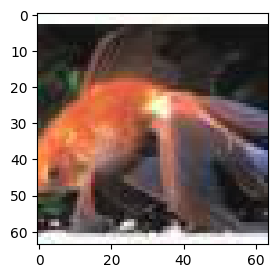

In [12]:
# Run to see the class 0
classes = 0
plus = np.random.randint(0, 50)
newset = test[0 + plus][0]

plt.figure(figsize=(3, 3))
plt.imshow(newset)

#### Step (b):

We will randomly select 9 classes to add to class 0 three times and collect information on the training.

The models are testable at the following [link](../notes/test.ipynb).

<div align="center">

| Iteration | 9 randomly classes                     | Early stop at epoch | Test Loss | Accuracy | F-Measure | Recall | Precision | Training time                   |
| --------- | -------------------------------------- | ------------------- | --------- | -------- | --------- | ------ | --------- | ------------------------------- |
| 1         | 143, 89, 35, 155, 47, 159, 81, 101, 84 | 110                 | 0.753     | 0.772    | 0.778     | 0.772  | 0.784     | 1 hours, 23 minutes, 43 seconds |
| 2         | 13, 185, 107, 169, 22, 10, 40, 106, 85 | 120                 | 0.731     | 0.754    | 0.760     | 0.754  | 0.766     | 1 hours, 31 minutes, 49 seconds |
| 3         | 79, 34, 147, 166, 73, 26, 176, 106, 32 | 97                  | 0.974     | 0.711    | 0.726     | 0.718  | 0.735     | 1 hours, 31 minutes, 49 seconds |

<p style="text-align: center">Table 14</p>
<p style="text-align: center">NP-ResNet18, 10 classes (20000 images with online aug. of 3 every 2 step), start BS 32, start LR 0.001, momentum 0.9, dropout_rb 0.5, dropout_fc 0.6</p>

</div>

##### Info about reference class

In the first iteration, the model correctly classified 48 out of 50 images of class 0. The model had some problems distinguishing classes 47 and 159 from the other classes, including class 0.

In the second iteration, the model correctly classified 42 out of 50 images of class 0. Looking at the confusion matrix, we can see that the model struggles more to distinguish the classes, confusing 7 out of 9 classes with class 0 (from 1 to 2 samples). Similarly, class 0 is confused with classes 40, 10, 185, 13 (from 1 to 3 samples), although it still has the second-highest number of correct classifications among all classes.

In the third iteration, the model correctly classified 46 out of 50 images of class 0. Of the 3 iterations, this one has the worst metrics. However, referring to class 0, we can see that the model is able to distinguish it well from the other classes.


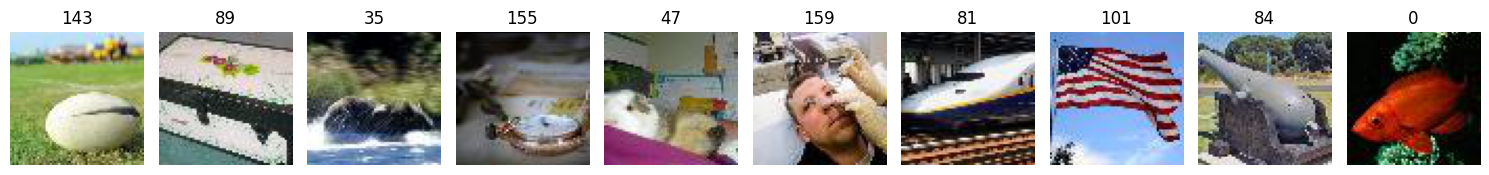

In [13]:
# Run to see the classes of first iteration: 143, 89, 35, 155, 47, 159, 81, 101, 84, 0
classes = [143, 89, 35, 155, 47, 159, 81, 101, 84, 0]
show_images(1, 10, (15, 15), classes)

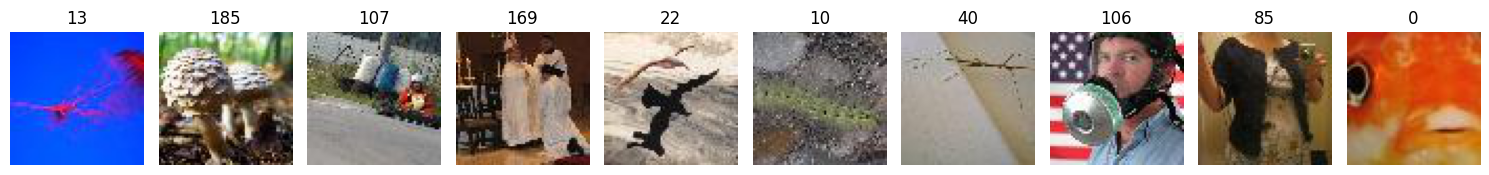

In [14]:
# Run to see the classes  of second iteration: 13, 185, 107, 169, 22, 10, 40, 106, 85, 0
classes = [13, 185, 107, 169, 22, 10, 40, 106, 85, 0]
show_images(1, 10, (15, 15), classes)

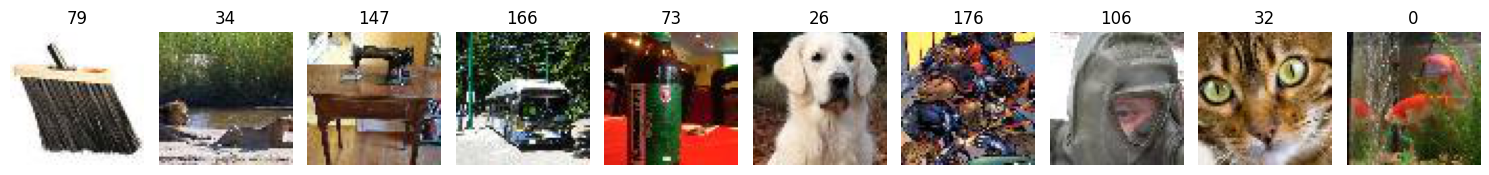

In [15]:
# Run to see the classes of third iteration: 79, 34, 147, 166, 73, 26, 176, 106, 32, 0
classes = [79, 34, 147, 166, 73, 26, 176, 106, 32, 0]
show_images(1, 10, (15, 15), classes)

<div align="center">
    <table> 
        <tr>
            <td style="text-align: center; padding: 0px; border-width: 0px;">
                <figure>
                    <img src="../notes/images/b1.png" style="width: 300px;"/>
                    <figcaption>Fig.4 - Last confusion matrix of first iteration</figcaption>
                </figure>
            </td>
            <td style="text-align: center; padding: 0px; border-width: 0px;">
                <figure>
                    <img src="../notes/images/b2.png" style="width: 300px;"/>
                    <figcaption>Fig.5 - Last confusion matrix of second iteration</figcaption>
                </figure>
            </td>
            <td style="text-align: center; padding: 0px; border-width: 0px;">
                <figure>
                    <img src="../notes/images/b3.png" style="width: 300px;"/>
                    <figcaption>Fig.6 - Last confusion matrix of third iteration</figcaption>
                </figure>
            </td>
        </tr>
    </table>
</div>

#### Step (c):

Now we will select the classes that we consider closest to the reference class and collect information regarding the model's performance.


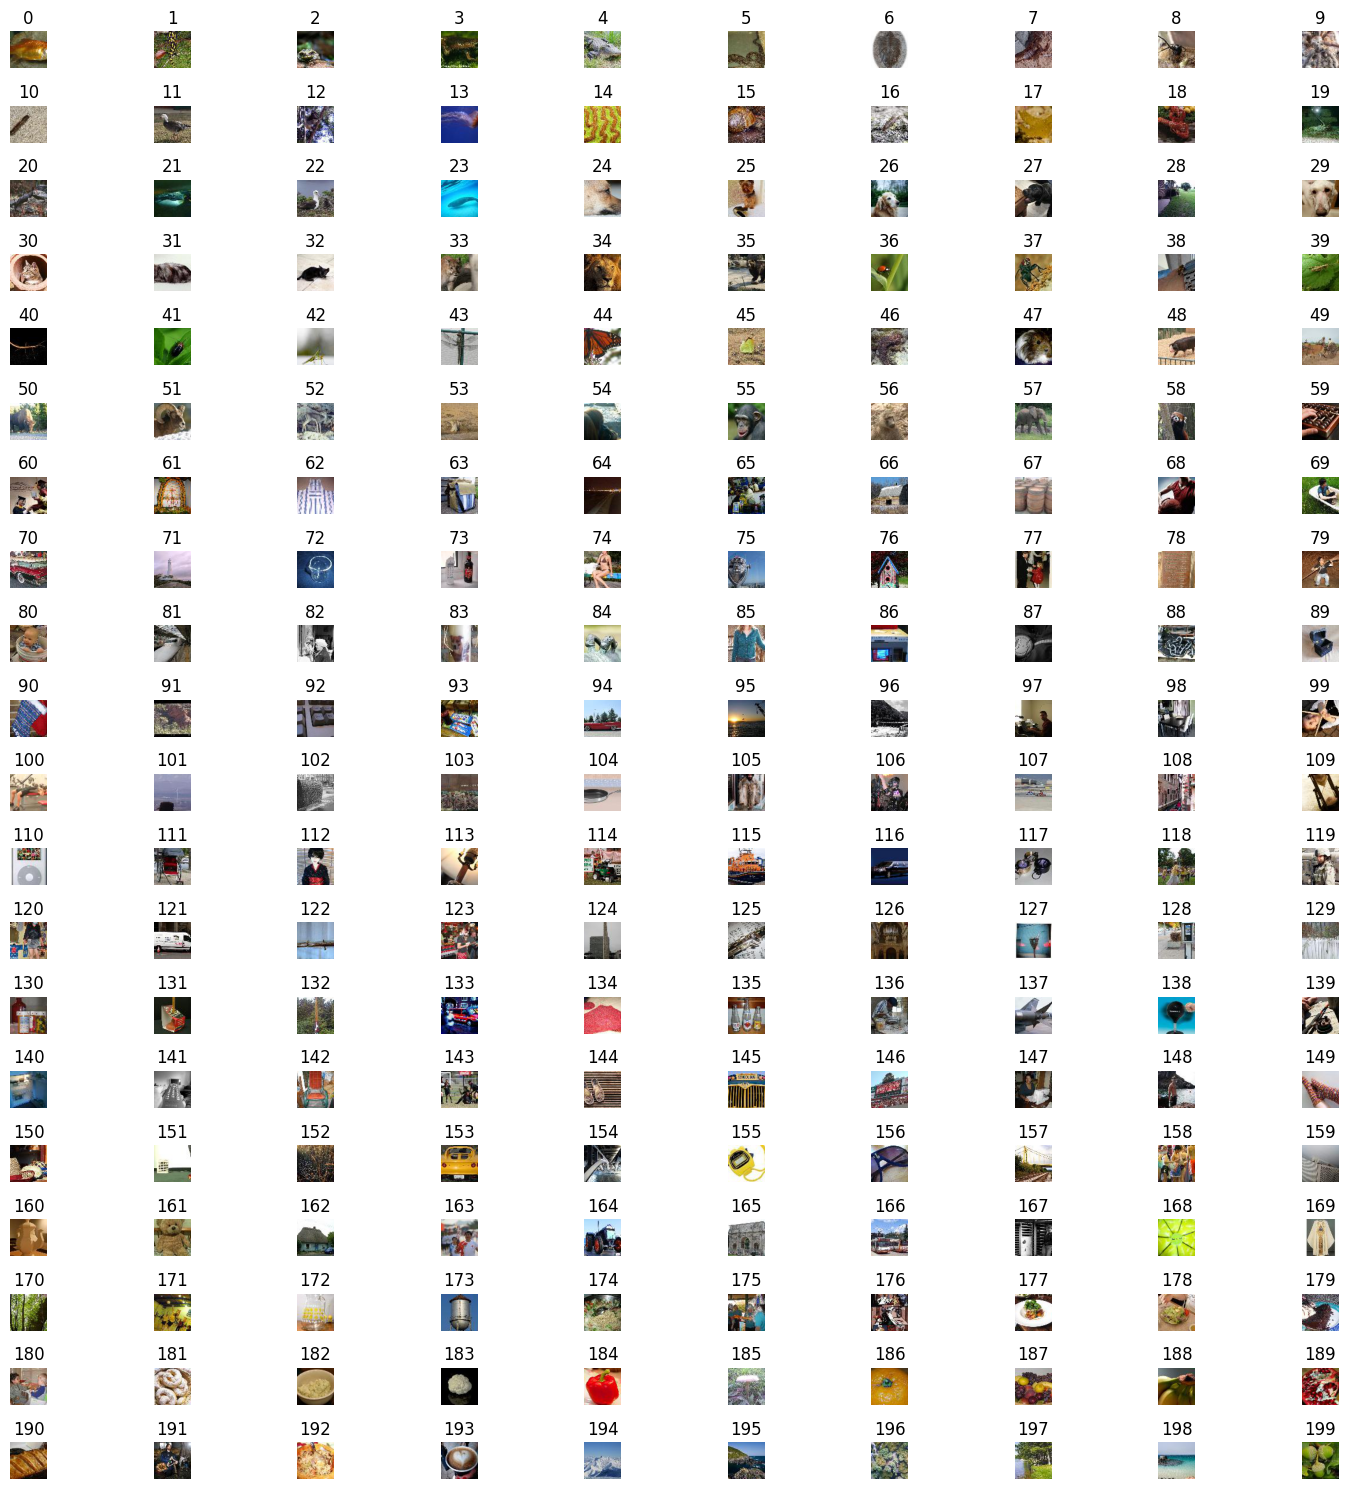

In [16]:
# Run to see the 200 classes
classes = [x for x in range(200)]
show_images(20, 10, (15, 15), classes)

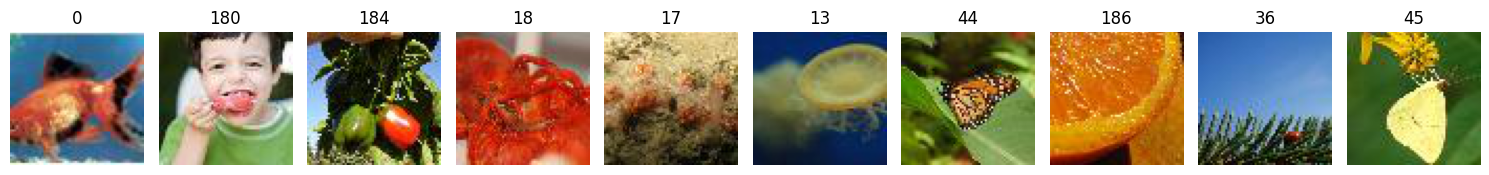

In [17]:
# Classes more reasoneable to class 0
classes = [0, 180, 184, 18, 17, 13, 44, 186, 36, 45]
show_images(1, 10, (15, 15), classes)

These classes are the most similar to the reference class based on characteristics such as colors, shapes, and size.


<div align="center">

| Early stop at epoch | Test Loss | Accuracy | F-Measure | Recall | Precision | Training time                   |
| ------------------- | --------- | -------- | --------- | ------ | --------- | ------------------------------- |
| 138                 | 0.690     | 0.802    | 0.806     | 0.802  | 0.810     | 1 hours, 43 minutes, 58 seconds |

<p style="text-align: center">Table 15</p>
<p style="text-align: center">NP-ResNet18, 10 classes (20000 images with online aug. of 3 every 2 step), start BS 32, start LR 0.001, momentum 0.9, dropout_rb 0.5, dropout_fc 0.6</p>

</div>

The model, contrary to expectations, achieved better performance. This is likely due not only to the particularity of the chosen reference subject but also to the background surrounding the subjects. An example of this is given by rockets and towers, which are confused not only because of their similar characteristics but also because of the background that often unites them, unlike the subjects chosen for test (c) where the backgrounds are very different from each other.

<div align="center">
    <figure>
        <img src="../notes/images/c.png" style="width: 500px;"/>
        <figcaption>Fig.7 - Confusion matrix of step (c)</figcaption>
    </figure>
</div>

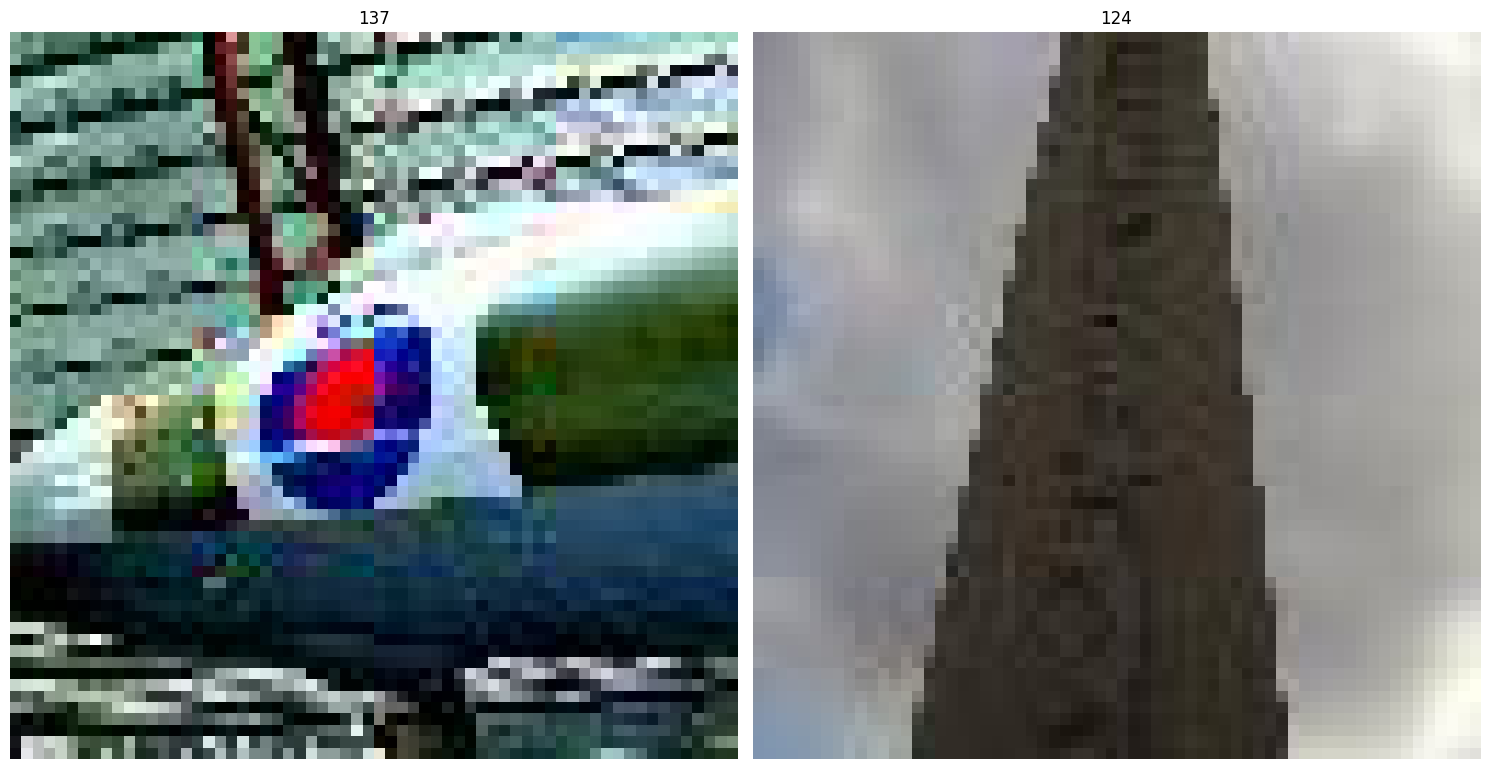

In [18]:
# Classes more reasoneable to class 0
classes = [137, 124]
show_images(1, 2, (15, 15), classes)

In [ ]:
# We have removed the unnecessary checkpoints because they were taking up too much space

# The command to run tensorboard are write for semplify the visualization.
# To prevent setup problem is suggested open a terminal in the "notes" folder and run the command.
tensorboard --logdir_spec ATrain:"../results/diff_num_classes/a/logsTrain",AVal:"../results/diff_num_classes/a/logsVal",B1Train:"../results/diff_num_classes/b1/logsTrain",B1Val:"../results/diff_num_classes/b1/logsVal",B2Train:"../results/diff_num_classes/b2/logsTrain",B2Val:"../results/diff_num_classes/b2/logsVal",B3Train:"../results/diff_num_classes/b3/logsTrain",B3Val:"../results/diff_num_classes/b3/logsVal",CTrain:"../results/diff_num_classes/c/logsTrain",CVal:"../results/diff_num_classes/c/logsVal"